In [41]:
import sys
sys.path.append("../../..")


In [42]:
import numpy as  np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from synthetic_data_generation.syn_gyn_module import *
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.3f}'.format
import numpy as np

# Generate example data

In [43]:
# Unit: number of products
num_units = 100

# Time: number of observations
max_timesteps = 52*5

# Metrics
sales = Metric("sales", metric_range = [0,30000] )
metrics = [sales]

# Interventions: control(no promo), (Email reminders), (20$ off)
num_interventions = 3


# unit covariates: location and size
type = UnitCov("cateory", categories= ["Activewear", "Outerwear", "Underwear"])
gender = UnitCov("size", categories= ["Men's Wear", "Women's Wear", "Unisex", "Children's Wear"])
unit_cov = [type, gender]

# intervention covariates: 
# Note that the assignments here makes the association between control and intervention 0, Email reminders and intervention 1, etc ..
treatment = IntCov("promo", discrete = True, categories= ["control","Email promo","20$ off coupons"], divisions = 3, assignment= [0,1,2])
int_cov = [treatment]

# initalize and generate
data = SyntheticDataModule(num_units, max_timesteps, num_interventions, metrics, unit_cov, int_cov , freq = "1w", rank = 4)




In [44]:
data.generate_init_factors(max_periods = 52, )

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [45]:
# Now we will define differen subpopulations andd specific effects on them for each intervention

# choose sub populations of interest where interventions will have different effects
subpop1 = lambda :type.unit_labels == 'Activewear'
subpop2 = lambda :type.unit_labels == 'Outerwear'
subpop3 = lambda :type.unit_labels == 'Underwear'
data.subpopulations_funcs = [subpop1, subpop2, subpop3]

# We will assume that intervention 1 will incure an in crease of 10% in sales for subpop3
#  and 2 will incure an increase of 10% in sales for all subpops
effects = [
   {"metric": sales, "intervention": 1, "subpop": subpop3, "effect": 0.2},
   {"metric": sales, "intervention": 2, "subpop": None, "effect": 0.1}, 
        ]

data.add_effects(effects)



In [46]:
# How to assign interventions? I.e., how to subsample the tensor?
# you do that by definine sequential periods, each period will to choose two things:
    # intervention_assignment: must be one of:
            #  random: completely at random
            #  random_unit: random for each unit (but constant in time)
            #  cov_unit: based on a covariate of the unit (could be randomized)
            #  or control: use control
    # unitl (integer): use this assignment from the last assigned point until this point in (relative) time.
# control example
t0 = 0
t1 = 3*52
period_1 =  {"intervention_assignment": "control", "until": t1-1}

# cov_unit example
# cov unit also need "assignment_subpop" policy which is a dictionary of subpopulations (keys) and probability of assignment (list of float in [0,1] that must be of length (num_interventions) and must sum to one)
t1 = 5*52
intervention_assignment = "cov_unit"
selection_subpop = {subpop1 : [0.3,0.3,0.4], subpop2 : [0.30,0.30,0.4], subpop3: [0.2, 0.4, 0.4] }
period_2 = {"intervention_assignment": intervention_assignment, "until": t1-1, "assignment_subpop": selection_subpop}

periods = [period_1, period_2]

tensor, df , tensor_noisy = data.generate([t0,t1-1])
tensor_ss, df_ss = data.auto_subsample(periods, tensor_noisy, df)
df_ss

(100, 260, 3, 1)
(100, 260, 3, 1)


,unit_id,time,cateory,size,intervention,sales,promo
0,0,2020-01-05,Underwear,Men's Wear,0,"25,988.690",control
1,0,2020-01-12,Underwear,Men's Wear,0,"25,875.787",control
2,0,2020-01-19,Underwear,Men's Wear,0,"25,795.812",control
3,0,2020-01-26,Underwear,Men's Wear,0,"25,743.363",control
4,0,2020-02-02,Underwear,Men's Wear,0,"25,707.369",control
...,...,...,...,...,...,...,...
25995,99,2024-11-24,Activewear,Women's Wear,2,"43,124.850",20$ off coupons
25996,99,2024-12-01,Activewear,Women's Wear,2,"44,312.207",20$ off coupons
25997,99,2024-12-08,Activewear,Women's Wear,2,"44,779.482",20$ off coupons
25998,99,2024-12-15,Activewear,Women's Wear,2,"44,550.641",20$ off coupons


### plot data from full tensor for unit 0 at different interventions

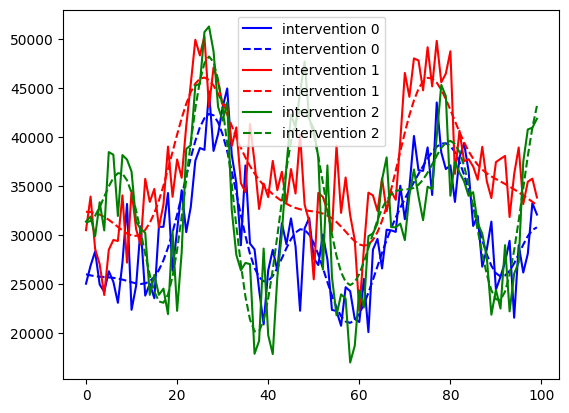

In [47]:
unit = np.argmax(subpop3())

plt.plot(tensor_noisy[unit,:100,0,], 'b-', label = "intervention 0")
plt.plot(tensor[unit,:100,0,], 'b--', label = "intervention 0")
plt.plot(tensor_noisy[unit,:100,1,], 'r-', label = "intervention 1")
plt.plot(tensor[unit,:100,1,], 'r--', label = "intervention 1")

plt.plot(tensor_noisy[unit,:100,2,], 'g-', label = "intervention 2")
plt.plot(tensor[unit,:100,2,], 'g--', label = "intervention 2")

plt.legend()
plt.show()

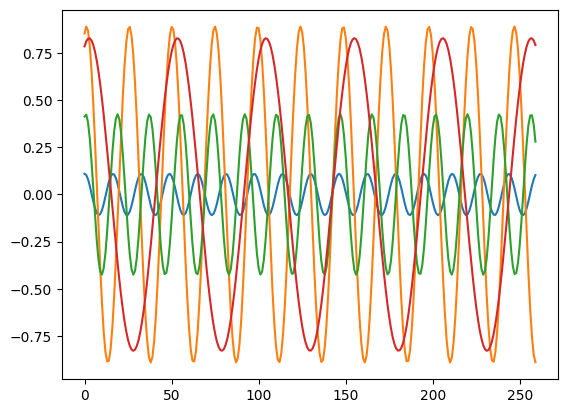

In [48]:
plt.plot(data.factors[1][:,:])

In [49]:
1/data.time_factor_periods

array([16.23935566, 24.57853881, 18.27345629, 50.79193924])

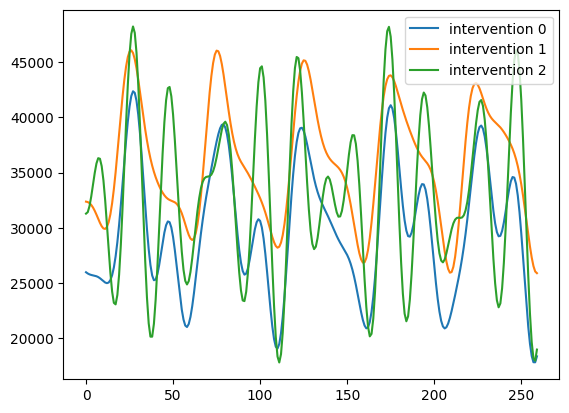

In [50]:
plt.plot(tensor[unit,:,0,], label = "intervention 0")
plt.plot(tensor[unit,:,1,], label = "intervention 1")
plt.plot(tensor[unit,:,2,], label = "intervention 2")
plt.legend()
plt.show()

# export data

In [40]:
data.export("product_sales",tensor, df_ss, dir = "" )